# Data Science in Chemistry

## Aim of this lab

To use and understand the role of data science and database in chemistry. 

### Objectives

* To understand the concepts of a REST-Ful Automated Programming Interface.  
* Learn how to use PubChem's API
* Learn how to use ChEMBl's API


## Background


PubChem is the largest chemical data resource.  Data in PubChem is stored in three databases PubChem Susbtance, PubChem Compound, and PubChem Bioassay.  Programmatic access is available via a Pug RESTful interface.  


### Restful APIs

Most chemical and biological databases have graphical user interfaces via a web portal.  For example, we can go directly to the PubChem web page for [aspirin](https://pubchem.ncbi.nlm.nih.gov/compound/Aspirin) and view all the chemical and biological PubChem has to offer, chemical identifiers, properties and assay testing results.  

However, in cheminformatics, you are often dealing with hundreds to thousands of chemicals, making manual retrieval for these properties.  Because of that, most scientific web sites that offer data acess allowed for programmatic retrieval.  This usually comes in the form of a [RESTFul](https://en.wikipedia.org/wiki/Representational_state_transfer) automated programming interface (API).  

RESTFul-style APIs allow access to databases via data via the construction of a Uniform Resource Locator (URL), a.k.a. a web address.  URLs can be read and integrated into any programming language, including Python, in order to automate the of specific data.  An example of some common API queries using PubChem's API is shown below in __Figure 1__.  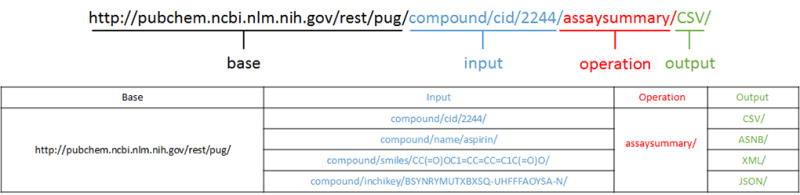

In this notebook, we will explore the APIs of the two most popuplar chemical databases in cheminformatics, [PubChem](https://pubchem.ncbi.nlm.nih.gov/) and [ChEMBl](https://www.ebi.ac.uk/chembl/).  In the PubChem databases, we will explore and retrieve some chemical information from our dataset.  Then, we will retrieve find a bioassay from chembl of interest to download for our QSAR modeling.  

### PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is an open database containing chemical molecules and their measured activities against biological assays, maintained by the [National Center for Biotechnology Information (NCBI)](https://www.ncbi.nlm.nih.gov/), part of [National Institutes of Health (NIH)](https://www.nih.gov/). It is the world’s largest freely available database of chemical information, collected from more than 770 data sources. There are three dynamically growing primary subdatabases, i.e., substances, compounds, and bioassay databases. 
As of August 2020, PubChem contains over 110 million unique chemical structures and over 270 million bioactivities ([_Nucleic Acids Res._(2021), __49__, D1388–D1395](https://academic.oup.com/nar/article/49/D1/D1388/5957164)). 

These compounds can be queried using a broad range of properties including chemical structure, name, fragments, chemical formula, molecular weight, XlogP, hydrogen bond donor and acceptor count, etc. There is no doubt that PubChem has become a key chemical information resource for scientists, students, and the general public.

Every data from PubChem is free to access through both the web interface and a programmatic interface. Here, we are going to learn how to use the API of PubChem to do some cool things.

### Programmatic access to PubChem

For some reasons, mainly historical, PubChem provides several ways of programmatic access to the open data.

* [PUG-REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest) is a Representational State Transfer (REST)-style version of the PUG (Power User Gateway) web service, with both the syntax of the HTTP requests and the available functions. It can also provide convenient access to information on PubChem records which are not reachable with other PUG services. 

* PUG-View is another REST-style web service for PubChem. It can provide full reports, including third-party textual annotation, for PubChem records.

*  PUG offers programmatic access to PubChem service via a single common gateway interface (CGI).

* PUG-SOAP uses the simple object access protocol (SOAP) to access PubChem data.

* PubChemRDF REST interface is a special interface for RDF-encoded PubChem data.

For more details about the PubChem API, please check out the introduction of [programmatic access](https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access) in the PubChem Docs.

In this tutorial, we will focus on the **PUG-REST** variant of the API, please refer to **Talktorial T011** for an introduction.

## Practical

In this section, we will discuss how to search PubChem based on a given query molecule using the PUG-REST access.

In [ ]:
import time
from pathlib import Path
from urllib.parse import quote

from IPython.display import Markdown, Image
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage

In [ ]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Simple examples for the PubChem API
Before querying PubChem for similar compounds, we provide some simple examples to show how to use the PubChem API. For more detail about the PubChem API, see [PUG-REST tutorial](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest-tutorial).

####  How to get the PubChem CID for a compound
For example, we will search for the PubChem Compound Identification (CID) for Aspirin by name.  

In [ ]:
# Get PubChem CID by name
name = "aspirin"

url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()
if "IdentifierList" in response:
    cid = response["IdentifierList"]["CID"][0]
else:
    raise ValueError(f"Could not find matches for compound: {name}")
print(f"PubChem CID for {name} is:\n{cid}")
# NBVAL_CHECK_OUTPUT

PubChem CID for aspirin is:
2244


#### Retrieve molecular properties based on a PubChem CID
We can get interesting properties for a compound through its PubChem CID, such as molecular weight, pKd, logP, etc. Here, we will search for the molecular weight for Aspirin.

In [ ]:
# Get mol weight for aspirin
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()

if "PropertyTable" in response:
    mol_weight = response["PropertyTable"]["Properties"][0]["MolecularWeight"]
else:
    raise ValueError(f"Could not find matches for PubChem CID: {cid}")
print(f"Molecular weight for {name} is:\n{mol_weight}")
# NBVAL_CHECK_OUTPUT

Molecular weight for aspirin is:
180.16


#### Depict a compound with PubChem

The 2D structure of Aspirin:

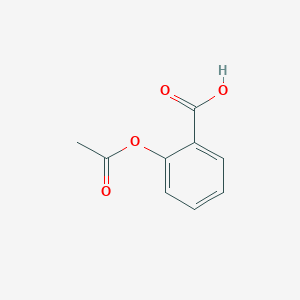

In [ ]:
# Get PNG image from PubChem
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/PNG"

r = requests.get(url)
r.raise_for_status()

display(Markdown("The 2D structure of Aspirin:"))
display(Image(r.content))

### Query PubChem for similar compounds
Use a `SMILES` string of a query compound to search for similar compounds in PubChem.

> Tip: You can check **Talktorial T001** to see how to do a similar operation with the ChEMBL database.

We define a function to query the PubChem service for similar compounds to the given one. The Tanimoto-based similarity between (2D) PubChem fingerprint will be calculated here. You can see [this paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0163-1) for more details about similarity evaluation in PubChem, and the [PubChem fingerprint specification](https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.pdf) for the details about PubChem fingerprint.

#### 1. Determine a query compound
In the following steps, we will search compounds similar to Gefitinib, an inhibitor for EGFR, from the PubChem service. You can also choose another compound which you are interested in.

The structure of Gefitinib:


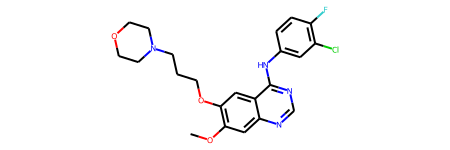

In [ ]:
query = "COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4"  # Gefitinib
print("The structure of Gefitinib:")
Chem.MolFromSmiles(query)

#### 2. Create task and get the job key

Input the canonical `SMILES` string for the given compound to create a new task, so we obtain a job key here. Note that this asynchronous API will not return the data immediately. In this case, the callback will be provided only when the requested resource is ready, which can be checked by the job key. So asynchronous requests are useful to work around certain slower operations. 

In [ ]:
def query_pubchem_for_similar_compounds(smiles, threshold=75, n_records=10):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key

In [ ]:
job_key = query_pubchem_for_similar_compounds(query)

#### 3. Download results when job finished
Check if the job finished within the time limit. The standard time limit in PubChem is 30 seconds (we can reset it). It means that if a request is not completed within the time limit, a timeout error will be returned. So, just wait patiently for the callback.

Then download results -  PubChem CIDs in this case -  when the job is finished.

In [ ]:
def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

In [ ]:
similar_cids = check_and_download(job_key)

Querying for job 4176789509392053309 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/4176789509392053309/cids/JSON....

#### 4. Get canonical SMILES for resulting molecules

In [ ]:
def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [ ]:
similar_smiles = smiles_from_pubchem_cids(similar_cids)

Then, we create the RDKit molecules and depict them.

,smiles,CIDs,ROMol
0,CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3...,208908,
1,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,176870,
2,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4=C...,68546,
3,CN(CCCNC(=O)C1CCCO1)C2=NC3=CC(=C(C=C3C(=N2)N)O...,2092,
4,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,25102847,

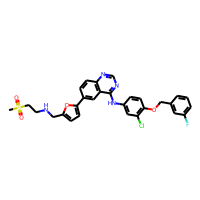
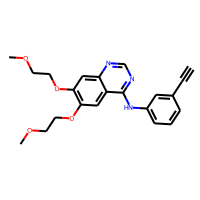
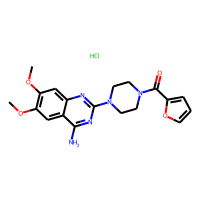
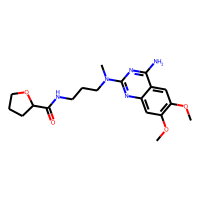
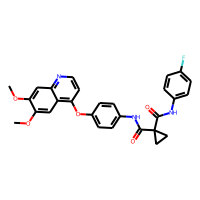

In [ ]:
query_results_df = pd.DataFrame({"smiles": similar_smiles, "CIDs": similar_cids})
PandasTools.AddMoleculeColumnToFrame(query_results_df, smilesCol="smiles")
query_results_df.head(5)

#### 5. Show the results
Show the compounds with images using RDKit's drawing functions.

In [ ]:
def multi_preview_smiles(query_smiles, query_name, similar_molecules_pd):
    """
    Show query and similar compounds in 2D structure representation.

    Parameters
    ----------
    query_smiles : str
        The SMILES string of query compound.
    query_name : str
        The name of query compound.
    similar_molecules_pd : pandas
        The pandas DataFrame which contains the SMILES string and CIDs of similar molecules.

    Returns
    -------
    MolsToGridImage
    """

    legends = [f"PubChem CID: {str(s)}" for s in similar_molecules_pd["CIDs"].tolist()]
    molecules = [Chem.MolFromSmiles(s) for s in similar_molecules_pd["smiles"]]
    query_smiles = Chem.MolFromSmiles(query_smiles)
    return MolsToGridImage(
        [query_smiles] + molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=([query_name] + legends),
        useSVG=True,
    )

### ChEMBL database
>"ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs." ([ChEMBL website](https://www.ebi.ac.uk/chembl/))

* Open large-scale bioactivity database
* **Current data content (as of 09.2020, ChEMBL 27):**
    * \>1.9 million distinct compounds
    * \>16 million activity values
    * Assays are mapped to ~13,000 targets
* **Data sources** include scientific literature, PubChem bioassays, Drugs for Neglected Diseases Initiative (DNDi), BindingDB database, ...
* ChEMBL data can be accessed via a [web-interface](https://www.ebi.ac.uk/chembl/), the [EBI-RDF platform](https://www.ncbi.nlm.nih.gov/pubmed/24413672) and the [ChEMBL webrescource client](https://github.com/chembl/chembl_webresource_client)

#### ChEMBL web services

* RESTful web service
* ChEMBL web service version 2.x resource schema: 

![ChEMBL web service schema](https://github.com/russodanielp/intro_cheminformatics/blob/master/Lab%2009%20-%20Data%20Science%20in%20Chemistry/images/chembl_webservices_schema_diagram.jpg?raw=1)

*Figure 1:* 
"[ChEMBL web service schema diagram](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/figure/F2/). The oval shapes represent ChEMBL web service resources and the line between two resources indicates that they share a common attribute. The arrow direction shows where the primary information about a resource type can be found. A dashed line indicates the relationship between two resources behaves differently. For example, the `Image` resource provides a graphical based representation of a `Molecule`."
Figure and description taken from: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).

#### ChEMBL webresource client

* Python client library for accessing ChEMBL data
* Handles interaction with the HTTPS protocol
* Lazy evaluation of results -> reduced number of network requests

### Compound activity measures

#### IC50 measure

* [Half maximal inhibitory concentration](https://en.wikipedia.org/wiki/IC50)
* Indicates how much of a particular drug or other substance is needed to inhibit a given biological process by half

![Wiki_Example_IC50_curve_demonstrating_visually_how_IC50_is_derived](https://github.com/russodanielp/intro_cheminformatics/blob/master/Lab%2009%20-%20Data%20Science%20in%20Chemistry/images/Wiki_Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png?raw=1)

*Figure 2:* Visual demonstration of how to derive an IC50 value: 
(i) Arrange inhibition data on y-axis and log(concentration) on x-axis. (ii) Identify maximum and minimum inhibition. (iii) The IC50 is the concentration at which the curve passes through the 50% inhibition level. Figure ["Example IC50 curve demonstrating visually how IC50 is derived"](https://en.wikipedia.org/wiki/IC50#/media/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png) by JesseAlanGordon is licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/).

#### pIC50 value

* To facilitate the comparison of IC50 values, which have a large value range and are given in different units (M, nM, ...), often pIC50 values are used
* The pIC50 is the negative log of the IC50 value when converted to molar units: 
    $ pIC_{50} = -log_{10}(IC_{50}) $, where $ IC_{50}$ is specified in units of M
* Higher pIC50 values indicate exponentially greater potency of the drug
* Note that the conversion can be adapted to the respective IC50 unit, e.g. for nM: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $

Other activity measures:

Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) and the half maximal effective concentration  [EC50](https://en.wikipedia.org/wiki/EC50).

## Practical

In the following, we want to download all molecules that have been tested against our target of interest, the **epidermal growth factor receptor** ([**EGFR**](https://www.uniprot.org/uniprot/P00533)) kinase.

### Connect to ChEMBL database

First, the ChEMBL webresource client as well as other Python libraries are imported.

In [ ]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [ ]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Next, we create resource objects for API access.

In [ ]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [ ]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Get target data (EGFR kinase)

* Get UniProt ID of the target of interest (EGFR kinase:  [P00533](http://www.uniprot.org/uniprot/P00533)) from [UniProt website](https://www.uniprot.org/)
* Use UniProt ID to get target information

Select a different UniProt ID, if you are interested in another target.

In [ ]:
uniprot_id = "P00533"

#### Fetch target data from ChEMBL

In [ ]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


#### Download target data from ChEMBL

The results of the query are stored in `targets`, a `QuerySet`, i.e. the results are not fetched from ChEMBL until we ask for it (here using `pandas.DataFrame.from_records`).

More information about the `QuerySet` datatype:

> QuerySets are lazy – the act of creating a QuerySet does not involve any database activity. You can stack filters together all day long, and Django will actually not run the query until the QuerySet is evaluated. 
([querysets-are-lazy](https://docs.djangoproject.com/en/3.0/topics/db/queries/#querysets-are-lazy))

In [ ]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION


#### Select target (target ChEMBL ID)

After checking the entries, we select the first entry as our target of interest:

`CHEMBL203`: It is a single protein and represents the human Epidermal growth factor receptor (EGFR, also named erbB1) 

In [ ]:
target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

Save selected ChEMBL ID.

In [ ]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL203


### Get bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [ ]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 8816, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [ ]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

#### Download bioactivity data from ChEMBL

Finally, we download the `QuerySet` in the form of a `pandas` `DataFrame`. 

> **Note**: This step should not take more than 2 minutes, if so try to rerun all cells starting from _"Fetch bioactivity data for the target from ChEMBL"_ or read this message below:

<details>
    
<summary>Load a local version of the data (in case you encounter any problems while fetching the data)</summary>
    
If you experience difficulties to query the ChEMBL database, we also provide the resulting dataframe you will construct in the cell below. If you want to use the saved version, use the following code instead to obtain `bioactivities_df`:
  
```python
# replace first line in cell below with this other line
bioactivities_df = pd.read_csv(DATA / "EGFR_bioactivities_CHEMBL27.csv.zip", index_col=0)
```

</details>

In [ ]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (8817, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0


Note that the first two rows describe the same bioactivity entry; we will remove such artifacts later during the deduplication step. Note also that we have columns for `standard_units`/`units` and `standard_values`/`values`; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

If we used the `units` and `values` columns, we would need to convert all values with many different units to nM:

In [ ]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M", "10'-7M", 'nmol'], dtype=object)

In [ ]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50


#### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `standard_unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `standard_value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [ ]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [ ]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

Use the parameter `inplace=True` to drop values in the current `DataFrame` directly.

In [ ]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (8816, 11)


**3. Keep only entries with "standard_unit == nM"** 

We only want to keep bioactivity entries in `nM`, thus we remove all entries with other units.

In [ ]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1' '/uM']
Number of non-nM entries:    69


In [ ]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [ ]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (8747, 11)


**4. Delete duplicate molecules**

Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

Note other choices could be to keep the one with the best value or a mean value of all assay results for the respective compound.

In [ ]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6059, 11)


**5. Reset "DataFrame" index**

Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.

In [ ]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


**6. Rename columns**

In [ ]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [ ]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6059, 11)


We now have a set of **5575** molecule ids with respective IC50 values for our target kinase.

### Get compound data

We have a `DataFrame` containing all molecules tested against EGFR (with the respective measured bioactivity). 

Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs. 

#### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [ ]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

#### Download compound data from ChEMBL

Again, we want to export the `QuerySet` object into a `pandas.DataFrame`. Given the data volume, **this can take some time.** For that reason, we will first obtain the list of records through `tqdm`, so we get a nice progress bar and some ETAs. We can then pass the list of compounds to the DataFrame.

In [ ]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/6059 [00:00<?, ?it/s]

In [ ]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6059, 2)


In [ ]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


#### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [ ]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


**2. Delete duplicate molecules**

In [ ]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


**3. Get molecules with canonical SMILES**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [ ]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [ ]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


Sanity check: Remove all molecules without a canonical SMILES string.

In [ ]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


### Output (bioactivity-compound) data
**Summary of compound and bioactivity data**

In [ ]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 6059


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [ ]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 6052


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [ ]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 6052 entries.


In [ ]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [ ]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


#### Add pIC50 values

As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [ ]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [ ]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [ ]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879


#### Draw compound data

Let's have a look at our collected data set.

First, we plot the pIC50 value distribution

array([[<AxesSubplot:title={'center':'pIC50'}>]], dtype=object)

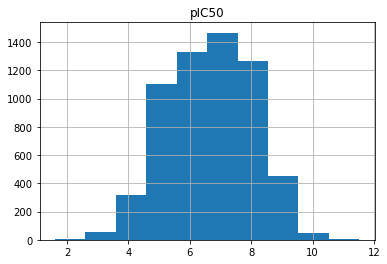

In [ ]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [ ]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [ ]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

Show the three most active molecules, i.e. molecules with the highest pIC50 values.

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL63786,0.003,nM,11.522879,
1,CHEMBL35820,0.006,nM,11.221849,
2,CHEMBL53711,0.006,nM,11.221849,

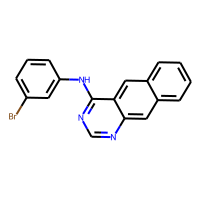
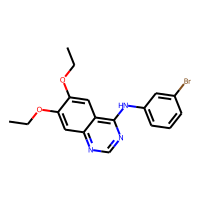
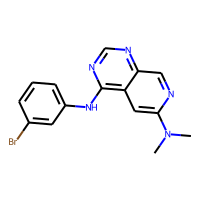

In [ ]:
output_df.drop("smiles", axis=1).head(3)

In [ ]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (6052, 5)


#### Freeze output data to ChEMBL 27

This is a technical step: Usually, we would continue to work with the dataset that we just created (latest dataset). 

However, here on the TeachOpenCADD platform, we prefer to freeze the dataset to a certain ChEMBL releases (i.e. [ChEMBL 27](http://doi.org/10.6019/CHEMBL.database.27)), 
so that this talktorial and other talktorials downstream in our CADD pipeline do not change in the future (helping us to maintain the talktorials).

<div class="alert alert-block alert-info">

<b>Note:</b> If you prefer to run this notebook on the latest dataset or if you want to use it for another target, please comment the cell below.

</div>

In [ ]:
# Disable this cell to unfreeze the dataset
output_df = pd.read_csv(
    DATA / "EGFR_compounds_ea055ef.csv", index_col=0, float_precision="round_trip"
)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


In [ ]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (5568, 5)


#### Write output data to file

We want to use this bioactivity-compound dataset in the following talktorials, thus we save the data as `csv` file. 
Note that it is advisable to drop the molecule column (which only contains an image of the molecules) when saving the data.

In [ ]:
output_df.to_csv(DATA / "EGFR_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


In [ ]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (5568, 5)
